# Analyzing Chinook database using SQL

In this project, we'll be working with the [Chinook](https://github.com/lerocha/chinook-database) database. The Chinook database is a fictional digital media store. It contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers' purchases. Here's the schema diagram for the Chinook database:
![Schema diagram for the Chinook database](chinook-schema.svg)

In [3]:
# Import modules.
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Render plots in the notebook.
%matplotlib inline

## Creating Helper Functions

In [4]:
def run_query(q):
    """Runs an SQL query and returns a dataframe"""
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    """Runs an SQL query"""
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    """Returns a list of all tables as a dataframe"""
    q = """SELECT name, type
        FROM sqlite_master
        WHERE type IN ("table","view");"""
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Number of tracks sold in Germany

In [6]:
q = """
WITH germany_tracks_sold AS
    (
    SELECT il.*
    FROM invoice_line il
    INNER JOIN invoice i
    ON il.invoice_id = i.invoice_id
    WHERE i.billing_country = 'Germany'
    )
SELECT
    g.name genre,
    COUNT(*) tracks_sold,
    CAST(COUNT(*) AS FLOAT) /
    (SELECT COUNT(*) FROM germany_tracks_sold) percentage_sold
FROM germany_tracks_sold gt
INNER JOIN track t
ON gt.track_id = t.track_id
INNER JOIN genre g
ON t.genre_id = g.genre_id
GROUP BY g.genre_id
ORDER BY 2 DESC
LIMIT 10;
"""

genre_sales_de = run_query(q)
genre_sales_de

,genre,tracks_sold,percentage_sold
0,Rock,194,0.573964
1,Metal,44,0.130178
2,Jazz,18,0.053254
3,Alternative & Punk,18,0.053254
4,Pop,15,0.044379
5,R&B/Soul,11,0.032544
6,Blues,8,0.023669
7,Latin,8,0.023669
8,Alternative,7,0.020710
9,Easy Listening,4,0.011834


In [7]:
genre_sales_de.set_index('genre', drop=True, inplace=True)

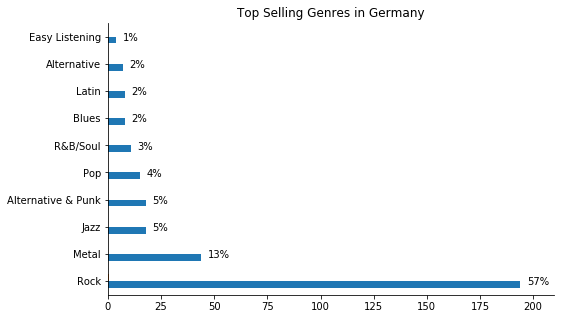

In [8]:
ax = genre_sales_de.plot.barh(
    title='Top Selling Genres in Germany',
    legend=False,
    figsize=(8, 5),
    xlim=(0, 210))

ax.set_ylabel('')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for i, label in enumerate(list(genre_sales_de.index)):
    score = genre_sales_de.loc[label, "tracks_sold"]
    label = (genre_sales_de.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 3, i - 0.15))

As we can see on the plot the most sold genres in Germany are rock, metal and jazz.

## Analyzing Employee Sales Performance

In [9]:
q = """
SELECT
    e.first_name || ' ' || e.last_name employee,
    e.hire_date,
    SUM(i.total) total_sales
FROM invoice i
INNER JOIN customer c
ON i.customer_id = c.customer_id
INNER JOIN employee e
ON c.support_rep_id = e.employee_id
GROUP BY e.employee_id
ORDER BY 3;
"""

employee_sales = run_query(q)
employee_sales.head()

,employee,hire_date,total_sales
0,Steve Johnson,2017-10-17 00:00:00,1393.92
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Jane Peacock,2017-04-01 00:00:00,1731.51


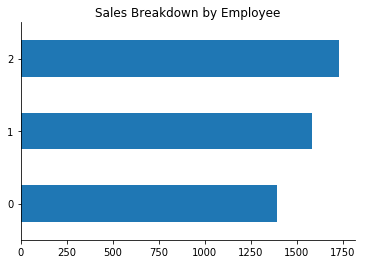

In [10]:
ax = employee_sales.plot.barh(title='Sales Breakdown by Employee',
                        legend=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
_ = ax.set_ylabel('')

The difference in sales roughly corresponds with the differences in hiring dates.

## Analyzing Sales by Country

In [48]:
q = """
WITH by_country AS
(
SELECT
    c.country,
    COUNT(DISTINCT(c.customer_id)) customers,
    SUM(total) total_sales,
    COUNT(*) total_orders,
    CASE
        WHEN COUNT(DISTINCT(c.customer_id)) > 1 THEN c.country
        ELSE 'Other'
    END AS country_or_other,
    CASE
        WHEN COUNT(DISTINCT(c.customer_id)) > 1 THEN 1
        ELSE 2
    END AS sort
FROM customer c
LEFT JOIN invoice i
ON c.customer_id = i.customer_id
GROUP BY c.country
ORDER BY 2 DESC
)

SELECT
    country_or_other country,
    SUM(customers) customers,
    SUM(total_sales) total_sales,
    SUM(total_sales) / SUM(total_orders) average_order,
    SUM(total_sales) / SUM(customers) customer_lifetime_value
FROM by_country
GROUP BY country_or_other
ORDER BY sort, total_sales DESC
;
"""

sales_by_country = run_query(q)
sales_by_country

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


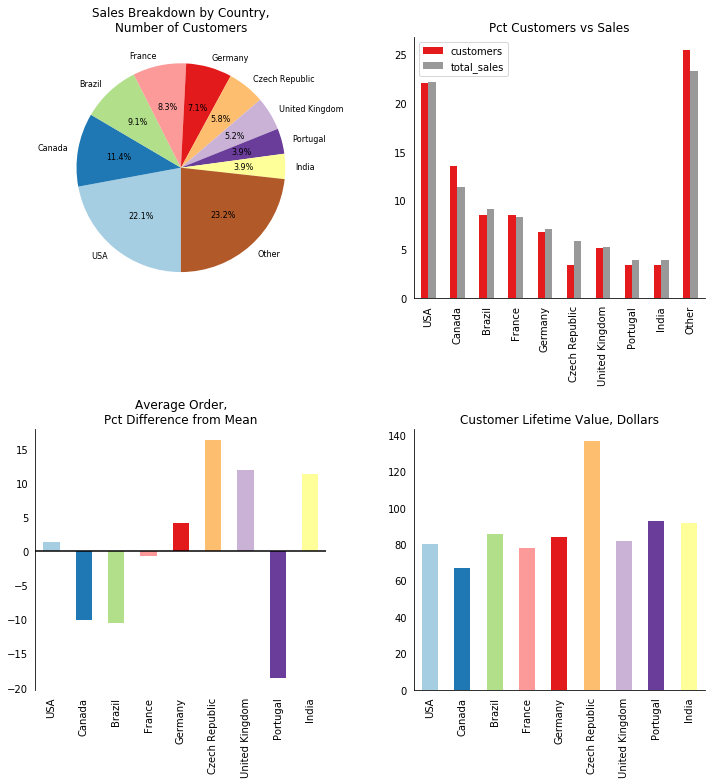

In [49]:
sales_by_country.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Paired(i) for i in np.linspace(0, 1, sales_by_country.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = sales_by_country["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Paired,
    fontsize=8,
    wedgeprops={'linewidth':0},
    autopct='%1.1f%%'
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = sales_by_country[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = sales_by_country["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top=False, right=False, left=False, bottom=False)
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = sales_by_country["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top=False, right=False, left=False, bottom=False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

The following countries have potential for market growth:
* Czech Republic
* United Kingdom
* India

# Purchase of individual tracks vs whole albums

In [13]:
q = """
WITH ia AS
(
SELECT
    il.invoice_id,
    album_id
FROM invoice_line il
INNER JOIN track t
ON il.track_id = t.track_id
GROUP BY il.invoice_id
)


SELECT
    album_purchase,
    COUNT(*) number_of_invoices,
    CAST(COUNT(*) AS float) / (SELECT COUNT(*) FROM ia) percent
FROM
(SELECT
    CASE
        WHEN
            (
            SELECT track_id
            FROM track
            WHERE album_id = ia.album_id

            EXCEPT

            SELECT track_id
            FROM invoice_line
            WHERE invoice_id = ia.invoice_id
            ) IS NULL

            AND

            (
            SELECT track_id
            FROM invoice_line
            WHERE invoice_id = ia.invoice_id

            EXCEPT

            SELECT track_id
            FROM track
            WHERE album_id = ia.album_id
            ) IS NULL
        THEN 'yes'
        ELSE 'no'
    END AS album_purchase
FROM ia)
GROUP BY album_purchase
"""

album_purchases = run_query(q)
album_purchases

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


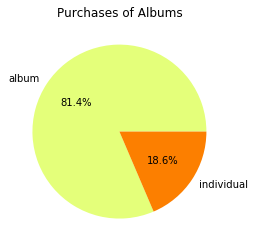

In [39]:
ax = album_purchases.set_index('album_purchase').rename({'yes':'individual', 'no':'album'}).\
plot.pie(y='number_of_invoices', title='Purchases of Albums',
         legend=False,
         colormap=plt.cm.Wistia,
         autopct='%1.1f%%')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
_ = ax.set_ylabel('')

There is 81 percent of customers who purchased a whole album and 19 percent of customers who purchased a collection of one or more individual tracks.

## Most popular artist in playlists

In [15]:
q = """
SELECT
    art.name artist,
    COUNT(DISTINCT(pt.playlist_id)) number_of_playlists
FROM playlist_track pt
INNER JOIN track t
ON pt.track_id = t.track_id
INNER JOIN album alb
ON t.album_id = alb.album_id
INNER JOIN artist art
ON alb.artist_id = art.artist_id
GROUP BY art.name
ORDER BY number_of_playlists DESC
"""

artists = run_query(q)
artists.head()

,artist,number_of_playlists
0,Eugene Ormandy,7
1,Academy of St. Martin in the Fields & Sir Nevi...,6
2,Berliner Philharmoniker & Herbert Von Karajan,6
3,English Concert & Trevor Pinnock,6
4,The King's Singers,6


Eugene Ormandy is used in the most playlists.

# Number of purchased and not purchased tracks

In [16]:
q = """
WITH purchased_or_not AS
(
SELECT
    CASE
        WHEN t.track_id IN (SELECT DISTINCT(track_id) FROM invoice_line)
        THEN 'yes'
        ELSE 'no'
    END AS purchased
FROM track t
)

SELECT
    purchased,
    COUNT(purchased) number_of_tracks,
    CAST(COUNT(purchased) AS float) / (SELECT COUNT(*) FROM purchased_or_not) percent
FROM
purchased_or_not
GROUP BY purchased
"""

purchased = run_query(q)
purchased

,purchased,number_of_tracks,percent
0,no,1697,0.484442
1,yes,1806,0.515558


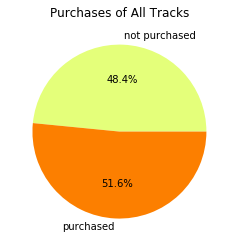

In [40]:
ax = purchased.set_index('purchased').rename({'yes':'purchased', 'no':'not purchased'}).\
plot.pie(y='number_of_tracks', title='Purchases of All Tracks',
         legend=False,
         colormap=plt.cm.Wistia,
         autopct='%1.1f%%')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
_ = ax.set_ylabel('')

There are more than half of tracks are purchased.

## Popularity of protected vs non-protected media types

In [18]:
q = """
WITH protected_or_not AS
(
SELECT
    CASE
        WHEN mt.name LIKE 'Protected%' THEN 'yes'
        ELSE 'no'
    END AS protected 
FROM invoice_line il
INNER JOIN track t
ON il.track_id = t.track_id
INNER JOIN media_type mt
ON t.media_type_id = mt.media_type_id
)

SELECT
    protected,
    COUNT(*) number_of_purchases
FROM protected_or_not
GROUP BY protected
"""
protected = run_query(q)
protected

,protected,number_of_purchases
0,no,4315
1,yes,442


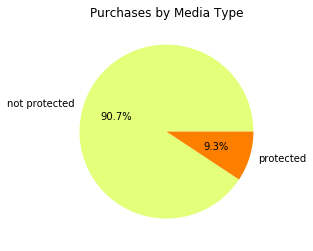

In [41]:
ax = protected.set_index('protected').rename({'yes':'protected', 'no':'not protected'}).\
plot.pie(y='number_of_purchases', title='Purchases by Media Type',
         legend=False,
         colormap=plt.cm.Wistia,
         autopct='%1.1f%%')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
_ = ax.set_ylabel('')

Non-protected tracks are sold 10 times as much as protected ones.